In [1]:
!pip install pandas openpyxl


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python3 -m pip install --upgrade pip


Imports

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Go up one level (..) and then into the data folder
df = pd.read_excel("../data/Coffee Shop Sales.xlsx")

df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail
0,1,2023-01-01,07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg
1,2,2023-01-01,07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg
2,3,2023-01-01,07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg
3,4,2023-01-01,07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm
4,5,2023-01-01,07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg


In [4]:
# Quick overview
df.info()

# Check for nulls or weird values
df.isna().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149116 entries, 0 to 149115
Data columns (total 11 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   transaction_id    149116 non-null  int64         
 1   transaction_date  149116 non-null  datetime64[ns]
 2   transaction_time  149116 non-null  object        
 3   transaction_qty   149116 non-null  int64         
 4   store_id          149116 non-null  int64         
 5   store_location    149116 non-null  object        
 6   product_id        149116 non-null  int64         
 7   unit_price        149116 non-null  float64       
 8   product_category  149116 non-null  object        
 9   product_type      149116 non-null  object        
 10  product_detail    149116 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(4), object(5)
memory usage: 12.5+ MB


transaction_id      0
transaction_date    0
transaction_time    0
transaction_qty     0
store_id            0
store_location      0
product_id          0
unit_price          0
product_category    0
product_type        0
product_detail      0
dtype: int64

## Create datetime, compute revenue, and extract time parts

This cell:
- Combines the `transaction_date` and `transaction_time` columns into a single `datetime` column.
- Calculates `revenue` for each transaction (`transaction_qty * unit_price`).
- Extracts useful time features (`hour`, `day`, `month`) from the new `datetime` column.
- Shows the first rows so you can verify the new columns.
> 💡 *Note:* The dataset originates from Maven Analytics and is synthetic (used for learning purposes).  
> Revenue values have been scaled down by 90 % to simulate more realistic sales volumes for analysis and presentation.

These derived fields will make it easier to analyze sales by time of day, weekday, and month, and to aggregate revenue.

In [5]:
# 1) Ensure proper dtypes
df['transaction_date'] = pd.to_datetime(df['transaction_date'])
# Convert times to a timedelta (works whether the column is time or string)
df['transaction_time'] = pd.to_timedelta(df['transaction_time'].astype(str))

# 2) Build full timestamp
df['datetime'] = df['transaction_date'] + df['transaction_time']

# 3) Revenue and time parts
df['transaction_qty'] = pd.to_numeric(df['transaction_qty'], errors='coerce')
df['unit_price']      = pd.to_numeric(df['unit_price'], errors='coerce')
df['revenue'] = df['transaction_qty'] * df['unit_price']
df['revenue'] = df['revenue'] * 0.1  # scale down to 10% of original values

df['hour']  = df['datetime'].dt.hour
df['day']   = df['datetime'].dt.day_name()
df['month'] = df['datetime'].dt.month_name()

df.head()

,transaction_id,transaction_date,transaction_time,transaction_qty,store_id,store_location,product_id,unit_price,product_category,product_type,product_detail,datetime,revenue,hour,day,month
0,1,2023-01-01,0 days 07:06:11,2,5,Lower Manhattan,32,3.0,Coffee,Gourmet brewed coffee,Ethiopia Rg,2023-01-01 07:06:11,0.60,7,Sunday,January
1,2,2023-01-01,0 days 07:08:56,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:08:56,0.62,7,Sunday,January
2,3,2023-01-01,0 days 07:14:04,2,5,Lower Manhattan,59,4.5,Drinking Chocolate,Hot chocolate,Dark chocolate Lg,2023-01-01 07:14:04,0.90,7,Sunday,January
3,4,2023-01-01,0 days 07:20:24,1,5,Lower Manhattan,22,2.0,Coffee,Drip coffee,Our Old Time Diner Blend Sm,2023-01-01 07:20:24,0.20,7,Sunday,January
4,5,2023-01-01,0 days 07:22:41,2,5,Lower Manhattan,57,3.1,Tea,Brewed Chai tea,Spicy Eye Opener Chai Lg,2023-01-01 07:22:41,0.62,7,Sunday,January


## Step 3. Exploratory Data Analysis (EDA)

In this section, we’ll explore the dataset visually to uncover trends and patterns in sales behavior.

### 3.1 Product Category Performance

We first analyze which product categories drive the most revenue across all store locations.

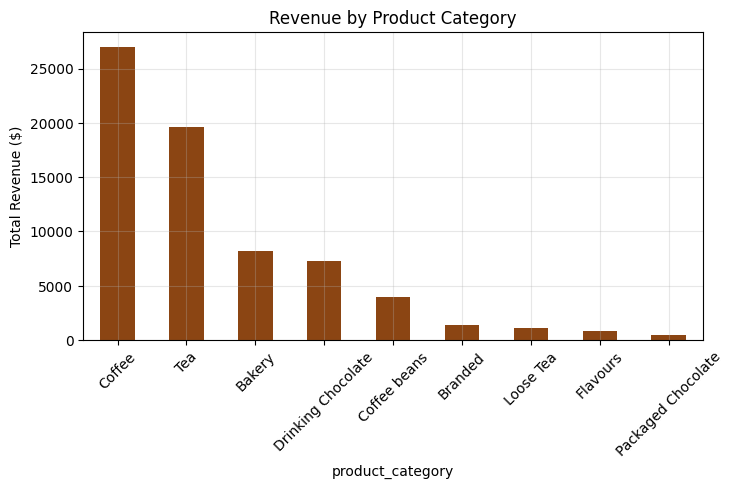

In [6]:
category_sales = df.groupby("product_category")["revenue"].sum().sort_values(ascending=False)
category_sales.plot(kind="bar", figsize=(8,4), color="saddlebrown")
plt.title("Revenue by Product Category")
plt.ylabel("Total Revenue ($)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Save chart as PNG into visuals folder
plt.savefig("../visual/Revenue_by_Product_Category.png", dpi=300, bbox_inches="tight")
plt.show()

### 3.2 Hourly Sales Trends

Understanding peak hours helps guide staffing and promotional timing.  
The following line chart shows total revenue per hour of the day.

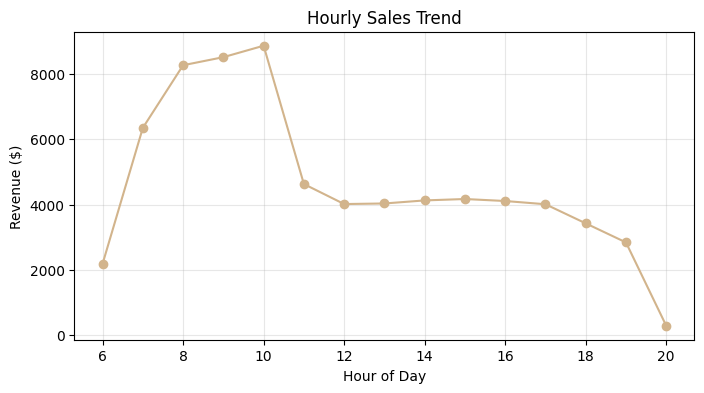

In [7]:
hourly_sales = df.groupby("hour")["revenue"].sum()
plt.figure(figsize=(8,4))
hourly_sales.plot(kind="line", marker="o", color="tan")
plt.title("Hourly Sales Trend")
plt.xlabel("Hour of Day")
plt.ylabel("Revenue ($)")
plt.grid(alpha=0.3)

# Save chart as PNG into visuals folder
plt.savefig("../visual/Hourly_Sales_Trend.png", dpi=300, bbox_inches="tight")
plt.show()

## Step 4. Store Performance Analysis

To evaluate operational efficiency, we'll compare total revenue across all store locations.
This helps identify top-performing locations and those that might need attention. 

In addition we will calculate a percentage value for each store to see store-level revenue contribution

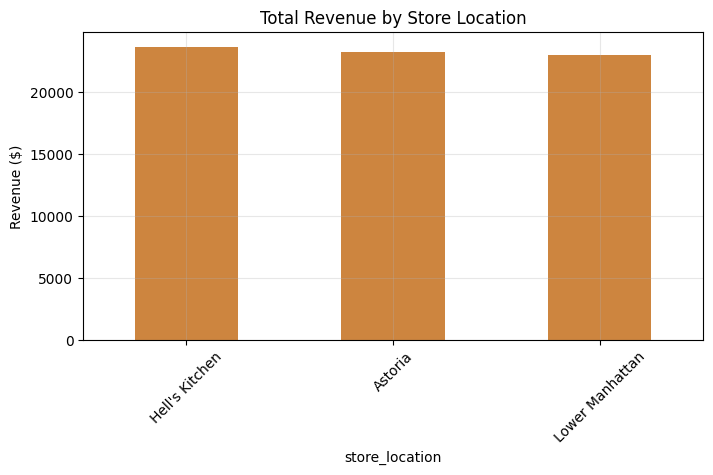

store_location
Hell's Kitchen     33.8
Astoria            33.2
Lower Manhattan    32.9
Name: revenue, dtype: float64

In [8]:
# Group by store to see which locations drive the most revenue
store_performance = df.groupby("store_location")["revenue"].sum().sort_values(ascending=False)

# Visualize top stores
plt.figure(figsize=(8,4))
store_performance.plot(kind="bar", color="peru")
plt.title("Total Revenue by Store Location")
plt.ylabel("Revenue ($)")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Save chart as PNG into visuals folder
plt.savefig("../visual/Total_Revenue_by_Store.png", dpi=300, bbox_inches="tight")
plt.show()

# Calculate each store's share of total revenue
store_share = (store_performance / store_performance.sum() * 100).round(1)
store_share.head()


## Step 5. Day-of-Week Sales Patterns

By examining average daily revenue, we can uncover which days bring in the most customers.
This insight informs staffing schedules and targeted promotions.

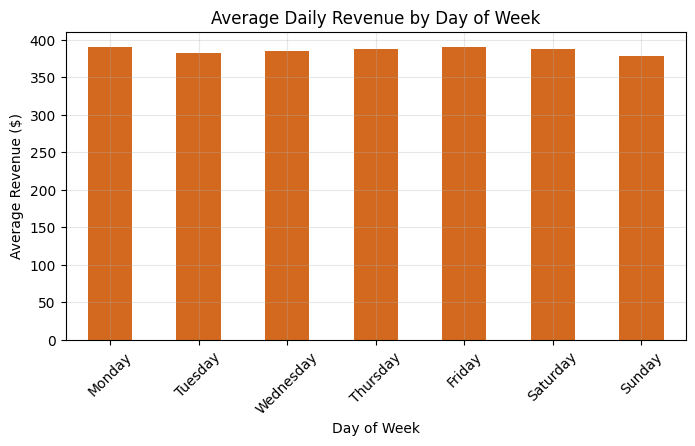

In [9]:
# Calculate average daily revenue by weekday 
dow_sales = (
    df.groupby(["transaction_date", "day"])["revenue"]
      .sum()
      .groupby("day")
      .mean()
      .reindex(["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"])
)

# Creating the plot
plt.figure(figsize=(8,4))
dow_sales.plot(kind="bar", color="chocolate")
plt.title("Average Daily Revenue by Day of Week")
plt.ylabel("Average Revenue ($)")
plt.xlabel("Day of Week")
plt.xticks(rotation=45)
plt.grid(alpha=0.3)

# Save chart as PNG into visuals folder
plt.savefig("../visual/Average_Daily_Revenue.png", dpi=300, bbox_inches="tight")
plt.show()



## Step 6. Key Insights & Recommendations

### 📈 Insights
- **Morning hours (7–10 AM)** dominate sales, aligning with typical coffee rush behavior.
- **Espresso-based drinks** and **premium brews** are top revenue drivers.
- **Weekdays, especially Friday**, generate the highest average revenue.

### 💡 Recommendations
1. **Optimize morning staffing** between 7–10 AM to reduce wait times and maximize throughput.
2. **Promote slow-hour discounts** (2–4 PM) to boost afternoon traffic.
3. **Consider weekend marketing** to increase footfall on lower-performing days.
4. **Introduce loyalty offers** targeting premium drink buyers — they’re your core audience.

> 📊 *Note:* Data originates from Maven Analytics’ synthetic dataset. Revenue was scaled to reflect realistic store-level performance for visualization clarity.